In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_absolute_error

In [3]:
from darts import TimeSeries
from darts.models import AutoARIMA, LightGBMModel

In [4]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set(font_scale=1.25)

In [5]:
##############################################################################################################################################################################################

In [6]:
data = pd.read_csv("train.csv")

In [7]:
train = pd.DataFrame()
train["Unit"] = data["БЕ"]
train["Date"] = data["Дата транзакции"]
train["RUB"] = data["Сумма в RUB"]

In [8]:
train_0 = train[train["Unit"]==0][["Date", "RUB"]]
train_0.set_index(pd.to_datetime(train_0["Date"]), inplace=True)
train_0.drop(["Date"], inplace=True, axis=1)

train_1 = train[train["Unit"]==1][["Date", "RUB"]]
train_1.set_index(pd.to_datetime(train_1["Date"]), inplace=True)
train_1.drop(["Date"], inplace=True, axis=1)

train_2 = train[train["Unit"]==2][["Date", "RUB"]]
train_2.set_index(pd.to_datetime(train_2["Date"]), inplace=True)
train_2.drop(["Date"], inplace=True, axis=1)

train_3 = train[train["Unit"]==3][["Date", "RUB"]]
train_3.set_index(pd.to_datetime(train_3["Date"]), inplace=True)
train_3.drop(["Date"], inplace=True, axis=1)

train_4 = train[train["Unit"]==4][["Date", "RUB"]]
train_4.set_index(pd.to_datetime(train_4["Date"]), inplace=True)
train_4.drop(["Date"], inplace=True, axis=1)

train_5 = train[train["Unit"]==5][["Date", "RUB"]]
train_5.set_index(pd.to_datetime(train_5["Date"]), inplace=True)
train_5.drop(["Date"], inplace=True, axis=1)

train_6 = train[train["Unit"]==6][["Date", "RUB"]]
train_6.set_index(pd.to_datetime(train_6["Date"]), inplace=True)
train_6.drop(["Date"], inplace=True, axis=1)

In [9]:
train_4_1d = train_4.resample('1D').sum()

In [10]:
train_4_1d_reindex = train_4_1d.reset_index(inplace=False)

In [11]:
series_1d = TimeSeries.from_dataframe(train_4_1d_reindex, time_col='Date', value_cols='RUB', freq='1d', fill_missing_dates=True)

In [12]:
train_1d_split, val_1d_split = series_1d.split_before(0.80)

In [14]:
best_result = np.inf
iteration = 0
best_params = {"j": 0, "k": 0, "z": 0}
for j in range(-1, -10, -2):
    for k in range(-1, -90, -3):
        for z in range(-1, -90, -6):
            model1d = LightGBMModel(lags=[j, k, z], output_chunk_length=180)
            model1d.fit(train_1d_split)
            prediction1d = model1d.predict(len(val_1d_split))
            fixed_prediction1d = prediction1d.pd_dataframe()
            current_result = mean_absolute_error(
                val_1d_split.pd_dataframe(), prediction1d.pd_dataframe()
            )
            iteration += 1
            if iteration % 10 == 0:
                print(f"{iteration} итерация")
            if current_result < best_result:
                print(f"New best result is {current_result}  MAE")
                best_result = current_result
                best_params["j"] = j
                best_params["k"] = k
                best_params["z"] = z
                print(f"best_params is {best_params.values()}")

New best result is 2730130.9726720275  MAE
best_params is dict_values([-1, -1, -1])
New best result is 1714455.226271475  MAE
best_params is dict_values([-1, -1, -13])
10 итерация
20 итерация
New best result is 1647151.3178882776  MAE
best_params is dict_values([-1, -4, -55])
30 итерация
40 итерация
50 итерация
60 итерация
70 итерация
New best result is 1507791.0402447137  MAE
best_params is dict_values([-1, -13, -85])
80 итерация
90 итерация
100 итерация
110 итерация
120 итерация
130 итерация
140 итерация
150 итерация
160 итерация
170 итерация
180 итерация
190 итерация
200 итерация
210 итерация
220 итерация
230 итерация
240 итерация
250 итерация
260 итерация
270 итерация
280 итерация
New best result is 1483467.8312847652  MAE
best_params is dict_values([-1, -55, -85])
290 итерация
300 итерация
310 итерация
320 итерация
330 итерация
340 итерация
350 итерация
360 итерация
370 итерация
380 итерация
390 итерация
400 итерация
410 итерация
420 итерация
430 итерация
440 итерация
450 итерация

In [15]:
# best_params = {'j': -3, 'k': -55, 'z': -85}
best_params

{'j': -3, 'k': -55, 'z': -85}

In [13]:
#fit, predict
model1d = LightGBMModel(lags=[-3, -55, -85], output_chunk_length=180)
model1d.fit(train_1d_split)
prediction1d = model1d.predict(len(val_1d_split))

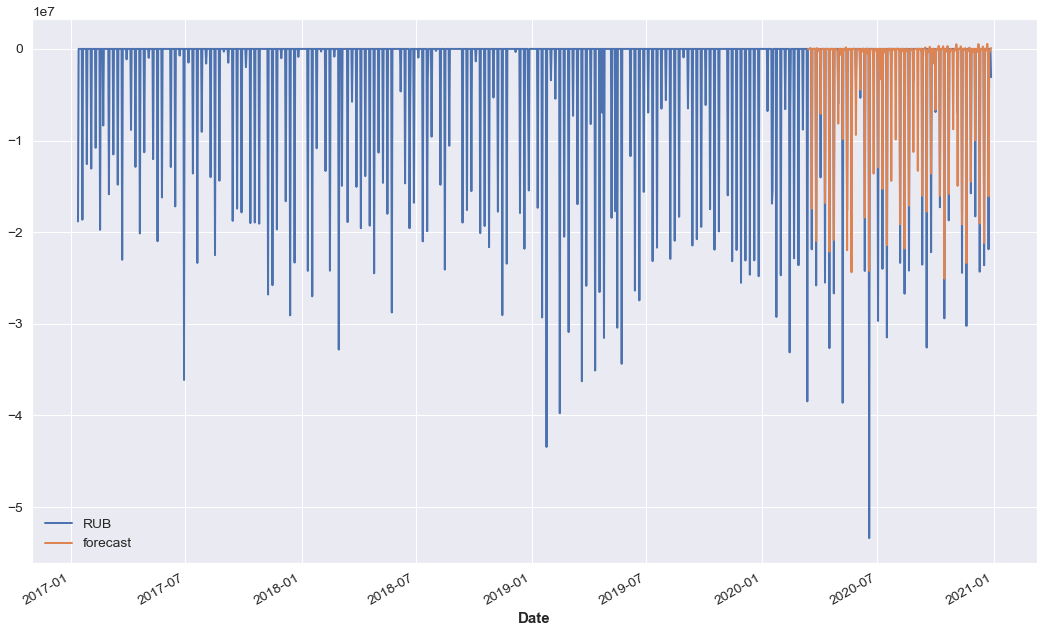

In [14]:
series_1d.plot()
prediction1d.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [15]:
fixed_prediction1d = prediction1d.pd_dataframe()
mean_absolute_error(val_1d_split.pd_dataframe(), prediction1d.pd_dataframe())

1192949.2186637805

In [16]:
fixed_prediction1d[fixed_prediction1d["RUB"]>0] = 0

In [17]:
mean_absolute_error(val_1d_split.pd_dataframe(), fixed_prediction1d)

1177049.4432088346

In [18]:
# Для этого БЕ больше моделей не подобрал

In [19]:
# Подготовка и постройка графика для val части
predict_series = fixed_prediction1d["RUB"]

In [20]:
val_df = pd.DataFrame()
val_df.index = predict_series.index
val_df["y"] = train_4_1d.loc["2020-03-13":]
val_df["yhat"] = predict_series

<AxesSubplot:xlabel='Date'>

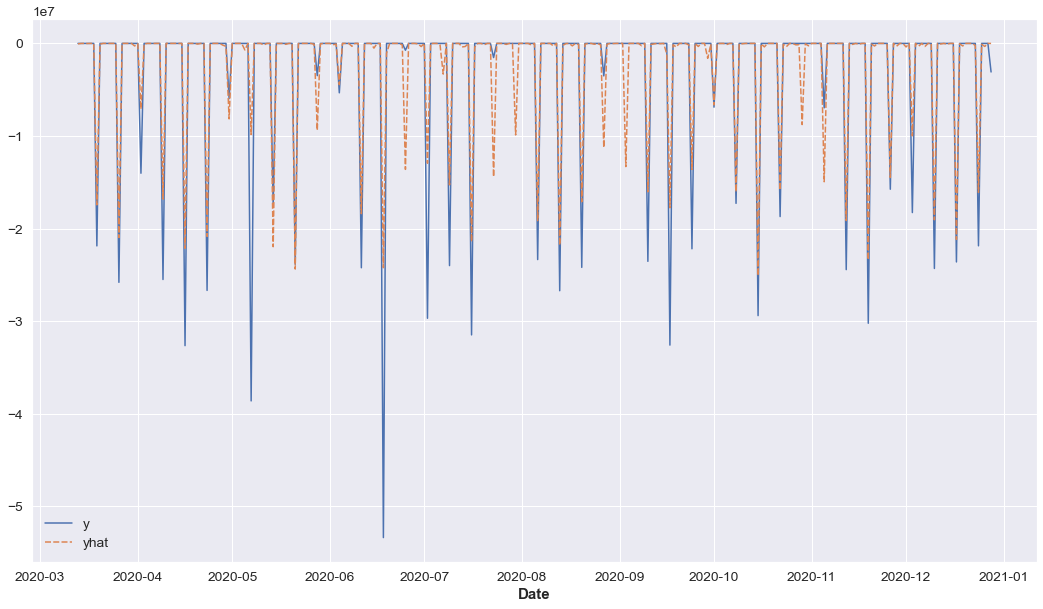

In [21]:
sns.lineplot(data=val_df)

In [22]:
# Делаем refit на полных данных для LightGBM
refit_model1d = LightGBMModel(lags=[-3, -55, -85], output_chunk_length=180)
refit_model1d.fit(series_1d)
refit_prediction1d = refit_model1d.predict(len(pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D"))+3)

In [23]:
refit_prediction1d.pd_dataframe()

component,RUB
Date,
2020-12-29,-3.738126e+06
2020-12-30,-5.158667e+05
2020-12-31,-3.945212e+06
2021-01-01,-3.892027e+06
2021-01-02,-3.794252e+05
...,...
2021-06-26,-3.341939e+05
2021-06-27,1.731310e+06
2021-06-28,-1.265825e+07


In [24]:
# Предикт с разрешением в 1 день
refit_fixed_prediction1d = refit_prediction1d.pd_dataframe()
refit_fixed_prediction1d[refit_fixed_prediction1d["RUB"]>0] = 0
refit_fixed_prediction1d = refit_fixed_prediction1d.iloc[3:]

In [25]:
#Собираем предикт вместе
train_4_ans = pd.DataFrame() # Вторник
#train_0_ans["Дата транзакции"] = pd.date_range(start="2021-01-05", end="2021-06-29", freq="7D") # legacy version
train_4_ans["Дата транзакции"] = pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D")
# Заполяняем сначала AUTOArima модель
train_4_ans["Сумма в RUB"] = refit_fixed_prediction1d["RUB"].values
train_4_ans["Сумма в RUB"] = train_4_ans["Сумма в RUB"].groupby(train_4_ans["Дата транзакции"].dt.month).cumsum().values

train_4_ans["Месяц"] = train_4_ans["Дата транзакции"].dt.month
train_4_ans["БЕ"] = 4


In [26]:
train_4_ans.to_csv("train_4_ans.csv")